# Beta clusters anno
- Define coarse beta cell clusters
- Compute markers of beta cell clusters

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

import math
from collections import defaultdict

import pickle as pkl
from sklearn.preprocessing import minmax_scale,maxabs_scale

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
from importlib import reload  
import helper as h
reload(h)
import helper as h
import sankey 
reload(sankey)
import sankey

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

ro.r('library("hypeR")')
ro.r("source(paste(Sys.getenv('WSCL'),'diabetes_analysis/data_exploration/','helper_hypeR.R',sep=''))")

R object with classes: ('list',) mapped to:
[SexpClosure, BoolSexpVector]
  value: <class 'rpy2.rinterface.SexpClosure'>
  <rpy2.rinterface.SexpClosure object at 0x7fc76a6661c0> [RTYPES.CLOSXP]
  visible: <class 'rpy2.rinterface.BoolSexpVector'>
  <rpy2.rinterface.BoolSexpVector object at 0x7fc76a6753c0> [RTYPES.LGLSXP]

In [2]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_save=path_data+'beta_subtype_general/'
path_genes='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'

In [ ]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [11]:
adata_rn_b=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')
adata_rn_b.shape

(102143, 30672)

In [12]:
genes_info=pd.read_table(path_genes+'genePrioritisation_beta.tsv',index_col=0)

In [3]:
# Add full gene symbol info
var=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad',backed='r'
           ).var.copy()
var['gene_symbol']=h.get_symbols(var.index)
# Check that gene symbols not nan -
if (var.gene_symbol=='nan').sum() :
        raise ValueError('Some gene symbols are nan - requires different parsing')

## Define clusters

### Clusters

In [6]:
ress=[0.3,0.4,0.5,0.6,0.7,0.8,1.5]

In [37]:
# Compute any missing cl resolutions
for res in ress:
    cl_name='leiden_r'+str(res)
    if cl_name not in adata_rn_b.obs.columns:
        sc.tl.leiden(adata_rn_b,resolution=res,key_added='leiden_r'+str(res))
        # Save new leiden - do not change old
        h.update_adata(
            adata_new=adata_rn_b, path=path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad',
            io_copy=False,
            add=[('obs',False,'leiden_r'+str(res),'leiden_r'+str(res))],rm=None)

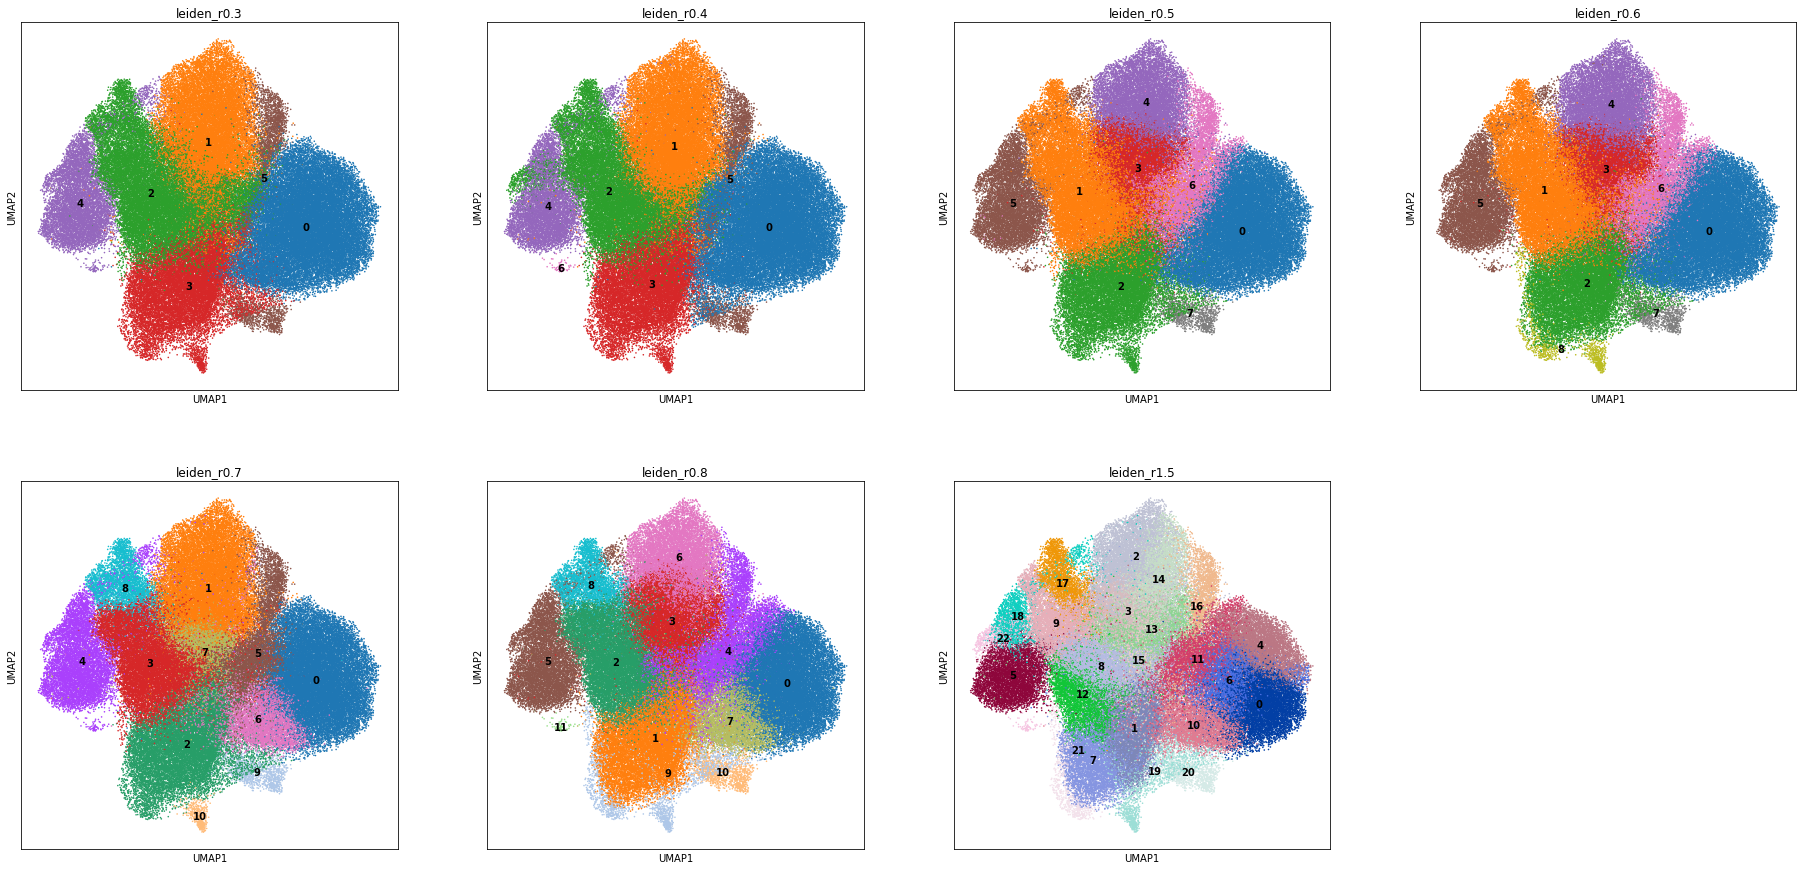

In [7]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata_rn_b,color=['leiden_r'+str(res) for res in ress],s=10,legend_loc='on data',
           ncols=4)

C: Use resolution 1.5 and then decide how fine clusters need to be (merge based on prior knowledge).

In [6]:
# Which clusterin will be used and what are clusters
clustering='leiden_r1.5'
clusters=list(adata_rn_b.obs[clustering].cat.categories)

In [9]:
display(adata_rn_b.obs[clustering].value_counts())

0     8642
1     7450
2     6560
3     6455
4     5979
5     5853
6     5751
7     5584
8     5431
9     5091
10    5065
11    4945
12    4660
13    4213
14    3984
15    3763
16    2913
17    2722
18    2335
19    1593
20    1189
21    1083
22     882
Name: leiden_r1.5, dtype: int64

### Analyse clusters

Proportion of cells of each group in each study, normalised by study

<AxesSubplot:>

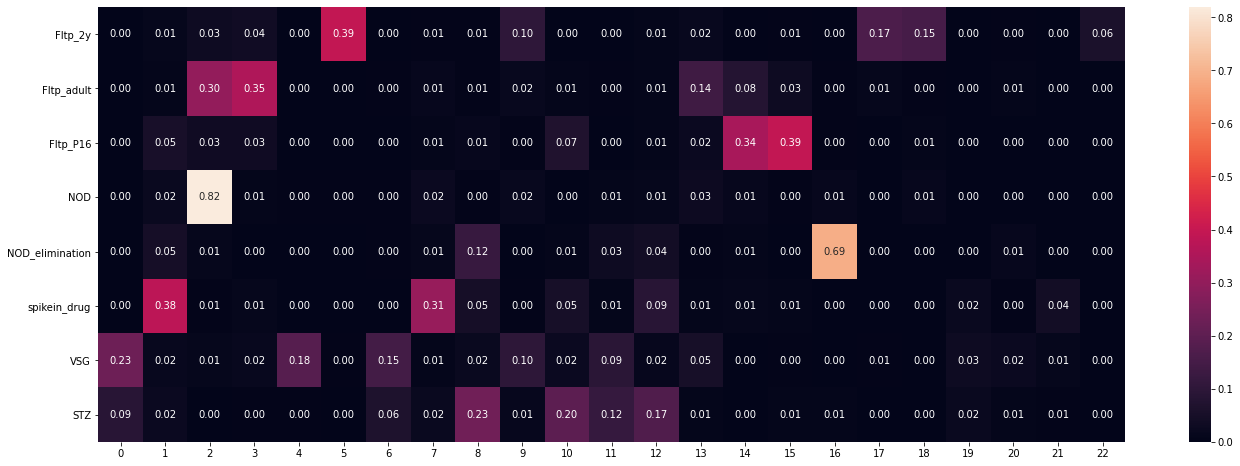

In [10]:
# Normalised by covar (study)
group_study_ratios=pd.DataFrame()
for (study,hc),ratio in adata_rn_b.obs.query('study!="embryo"').\
        groupby('study',observed=True)[clustering].\
        value_counts(normalize=True,sort=False).iteritems():
    group_study_ratios.at[study,hc]=ratio
fig,ax=plt.subplots(figsize=(group_study_ratios.shape[1],group_study_ratios.shape[0]))
sb.heatmap(group_study_ratios,ax=ax,annot=True,fmt='.2f')

Proportion of cells of each group in each sex, normalised by cluster

<AxesSubplot:>

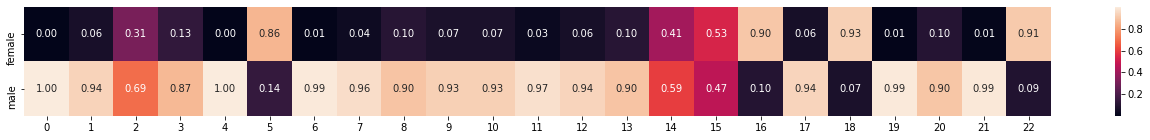

In [16]:
# Normalised by cluster
group_study_ratios=pd.DataFrame()
for (study,hc),ratio in adata_rn_b.obs.query('study!="embryo"').\
        groupby(clustering,observed=True)['sex'].\
        value_counts(normalize=True,sort=False).iteritems():
    group_study_ratios.at[study,hc]=ratio
group_study_ratios=group_study_ratios.T
group_study_ratios=group_study_ratios[[str(cl)
    for cl in sorted([int(cl) for cl in group_study_ratios])]]
fig,ax=plt.subplots(figsize=(group_study_ratios.shape[1],group_study_ratios.shape[0]))
sb.heatmap(group_study_ratios,ax=ax,annot=True,fmt='.2f')

Proportion of cells of each group in each sample, normalised by sample

In [20]:
# Ratios
group_sample_ratios=pd.DataFrame()
adata_rn_b.obs['studyparsed_design_sample']=[
    '_'.join(i) for i in 
     zip(adata_rn_b.obs.study_parsed,adata_rn_b.obs.design,adata_rn_b.obs.file)]
for (sample,hc),ratio in adata_rn_b.obs.query('study!="embryo"').\
        groupby('studyparsed_design_sample',observed=True)['leiden_r1.5'].\
        value_counts(normalize=True,sort=False).iteritems():
    group_sample_ratios.at[sample,hc]=ratio 
group_sample_ratios.fillna(0,inplace=True)    

# Add design and study info for sorting and anno
group_sample_ratios['design']=[
    adata_rn_b.obs.query('studyparsed_design_sample==@sample').design.values[0]  
    for sample in group_sample_ratios.index]
group_sample_ratios['design']=pd.Categorical(group_sample_ratios['design'],
              categories=['mRFP','mTmG','mGFP',
              'head_Fltp-','tail_Fltp-', 'head_Fltp+', 'tail_Fltp+',
              'IRE1alphafl/fl','IRE1alphabeta-/-', 
              '8w','14w', '16w',
              'DMSO_r1','DMSO_r2', 'DMSO_r3','GABA_r1','GABA_r2', 'GABA_r3',
                   'A1_r1','A1_r2','A1_r3','A10_r1','A10_r2', 'A10_r3',  'FOXO_r1', 'FOXO_r2', 'FOXO_r3', 
              'E12.5','E13.5','E14.5', 'E15.5', 
              'chow_WT','sham_Lepr-/-','PF_Lepr-/-','VSG_Lepr-/-',   
              'control','STZ', 'STZ_GLP-1','STZ_estrogen', 'STZ_GLP-1_estrogen',
                  'STZ_insulin','STZ_GLP-1_estrogen+insulin' 
            ],
            ordered=True)
group_sample_ratios['study']=[
    adata_rn_b.obs.query('studyparsed_design_sample==@sample').study_parsed.values[0]  
    for sample in group_sample_ratios.index]
# Sort rows 
group_sample_ratios=group_sample_ratios.sort_values(['study','design'])
# Save study info
studies=group_sample_ratios.study.values
# Add palete
sc.pl._utils._set_default_colors_for_categorical_obs(adata_rn_b, 'study_parsed')
study_cmap=dict(zip(adata_rn_b.obs.study_parsed.cat.categories,
                    adata_rn_b.uns['study_parsed_colors']))
study_colors=[study_cmap[s] for s in studies]
# Drop unused cols
group_sample_ratios.drop(['study','design'],axis=1,inplace=True)
# Sort/select columns
group_sample_ratios=group_sample_ratios[adata_rn_b.obs['leiden_r1.5'].cat.categories]

Text(0.5, 1.0, 'sample proportion\n')

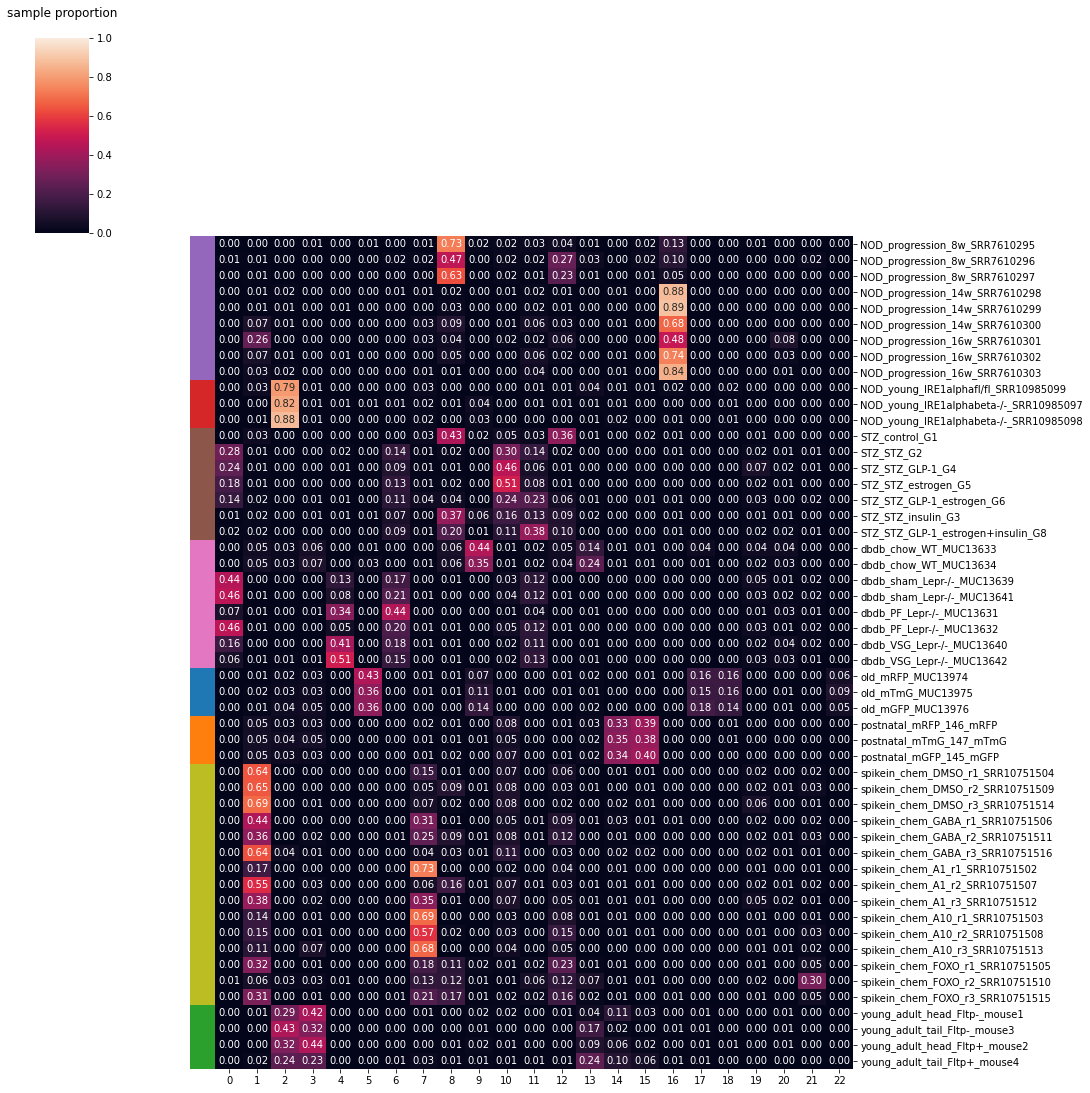

In [22]:
g=sb.clustermap(group_sample_ratios,row_colors=study_colors,annot=True,fmt='.2f',
             col_cluster=False,row_cluster=False,
             xticklabels=True,yticklabels=True,figsize=(15,15),vmin=0,vmax=1)
g.cax.set_title("sample proportion\n")

Proportion of cells of each study in each group, normalised by cluster

<AxesSubplot:>

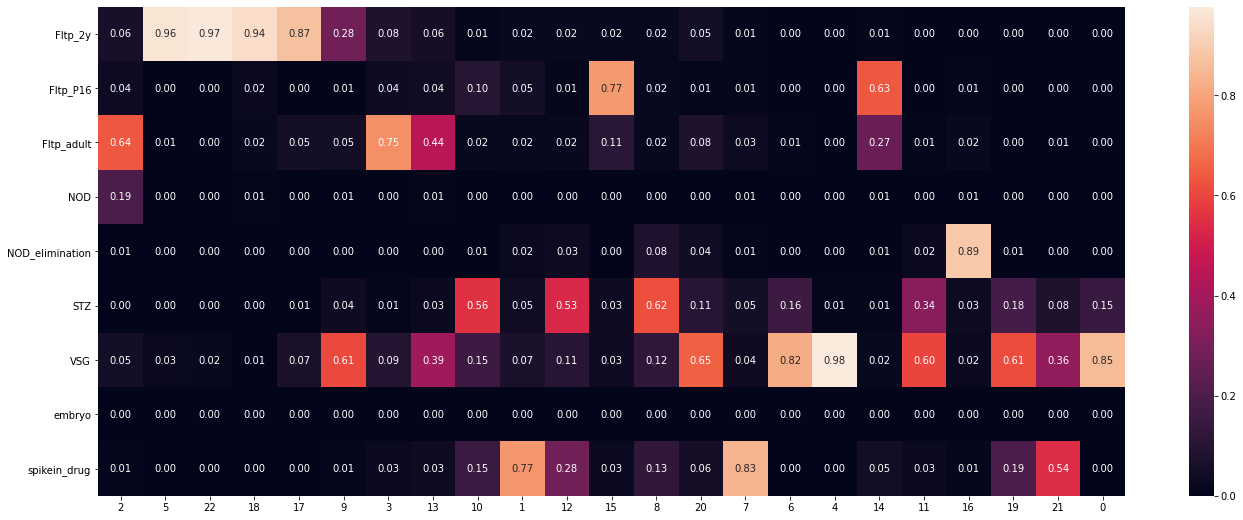

In [22]:
group_study_ratios=pd.DataFrame()
for (study,hc),ratio in adata_rn_b.obs.query('study!="embryo"').\
        groupby(clustering,observed=True)['study'].\
        value_counts(normalize=True,sort=False).iteritems():
    group_study_ratios.at[study,hc]=ratio
group_study_ratios= group_study_ratios.T
fig,ax=plt.subplots(figsize=(group_study_ratios.shape[1],group_study_ratios.shape[0]))
sb.heatmap(group_study_ratios,ax=ax,annot=True,fmt='.2f')

Sample proportions across clusters, normalised by cluster

In [23]:
# Ratios
group_sample_ratios=pd.DataFrame()
for (sample,hc),ratio in adata_rn_b.obs.query('study!="embryo"').\
        groupby(clustering,observed=True)['study_sample_design'].\
        value_counts(normalize=True,sort=False).iteritems():
    group_sample_ratios.at[sample,hc]=ratio 
group_sample_ratios.fillna(0,inplace=True) 
group_sample_ratios=group_sample_ratios.T

# Add design and study info for sorting and anno
group_sample_ratios['design']=[
    adata_rn_b.obs.query('study_sample_design==@sample').design.values[0]  
    for sample in group_sample_ratios.index]
group_sample_ratios['design']=pd.Categorical(group_sample_ratios['design'],
              categories=['mRFP','mTmG','mGFP',
              'head_Fltp-','tail_Fltp-', 'head_Fltp+', 'tail_Fltp+',
              'IRE1alphafl/fl','IRE1alphabeta-/-', 
              '8w','14w', '16w',
              'DMSO_r1','DMSO_r2', 'DMSO_r3','GABA_r1','GABA_r2', 'GABA_r3',
                   'A1_r1','A1_r2','A1_r3','A10_r1','A10_r2', 'A10_r3',  'FOXO_r1', 'FOXO_r2', 'FOXO_r3', 
              'E12.5','E13.5','E14.5', 'E15.5', 
              'chow_WT','sham_Lepr-/-','PF_Lepr-/-','VSG_Lepr-/-',   
              'control','STZ', 'STZ_GLP-1','STZ_estrogen', 'STZ_GLP-1_estrogen',
                  'STZ_insulin','STZ_GLP-1_estrogen+insulin' 
            ],
            ordered=True)
group_sample_ratios['study']=[
    adata_rn_b.obs.query('study_sample_design==@sample').study.values[0]  
    for sample in group_sample_ratios.index]
# Sort rows 
group_sample_ratios=group_sample_ratios.sort_values(['study','design'])
# Save study info
studies=group_sample_ratios.study.values
sc.pl._utils._set_default_colors_for_categorical_obs(adata_rn_b, 'study')
study_cmap=dict(zip(adata_rn_b.obs.study.cat.categories,adata_rn_b.uns['study_colors']))
study_colors=[study_cmap[s] for s in studies]
# Drop unused cols
group_sample_ratios.drop(['study','design'],axis=1,inplace=True)
# Sort/select columns
group_sample_ratios=group_sample_ratios[adata_rn_b.obs[clustering].cat.categories]

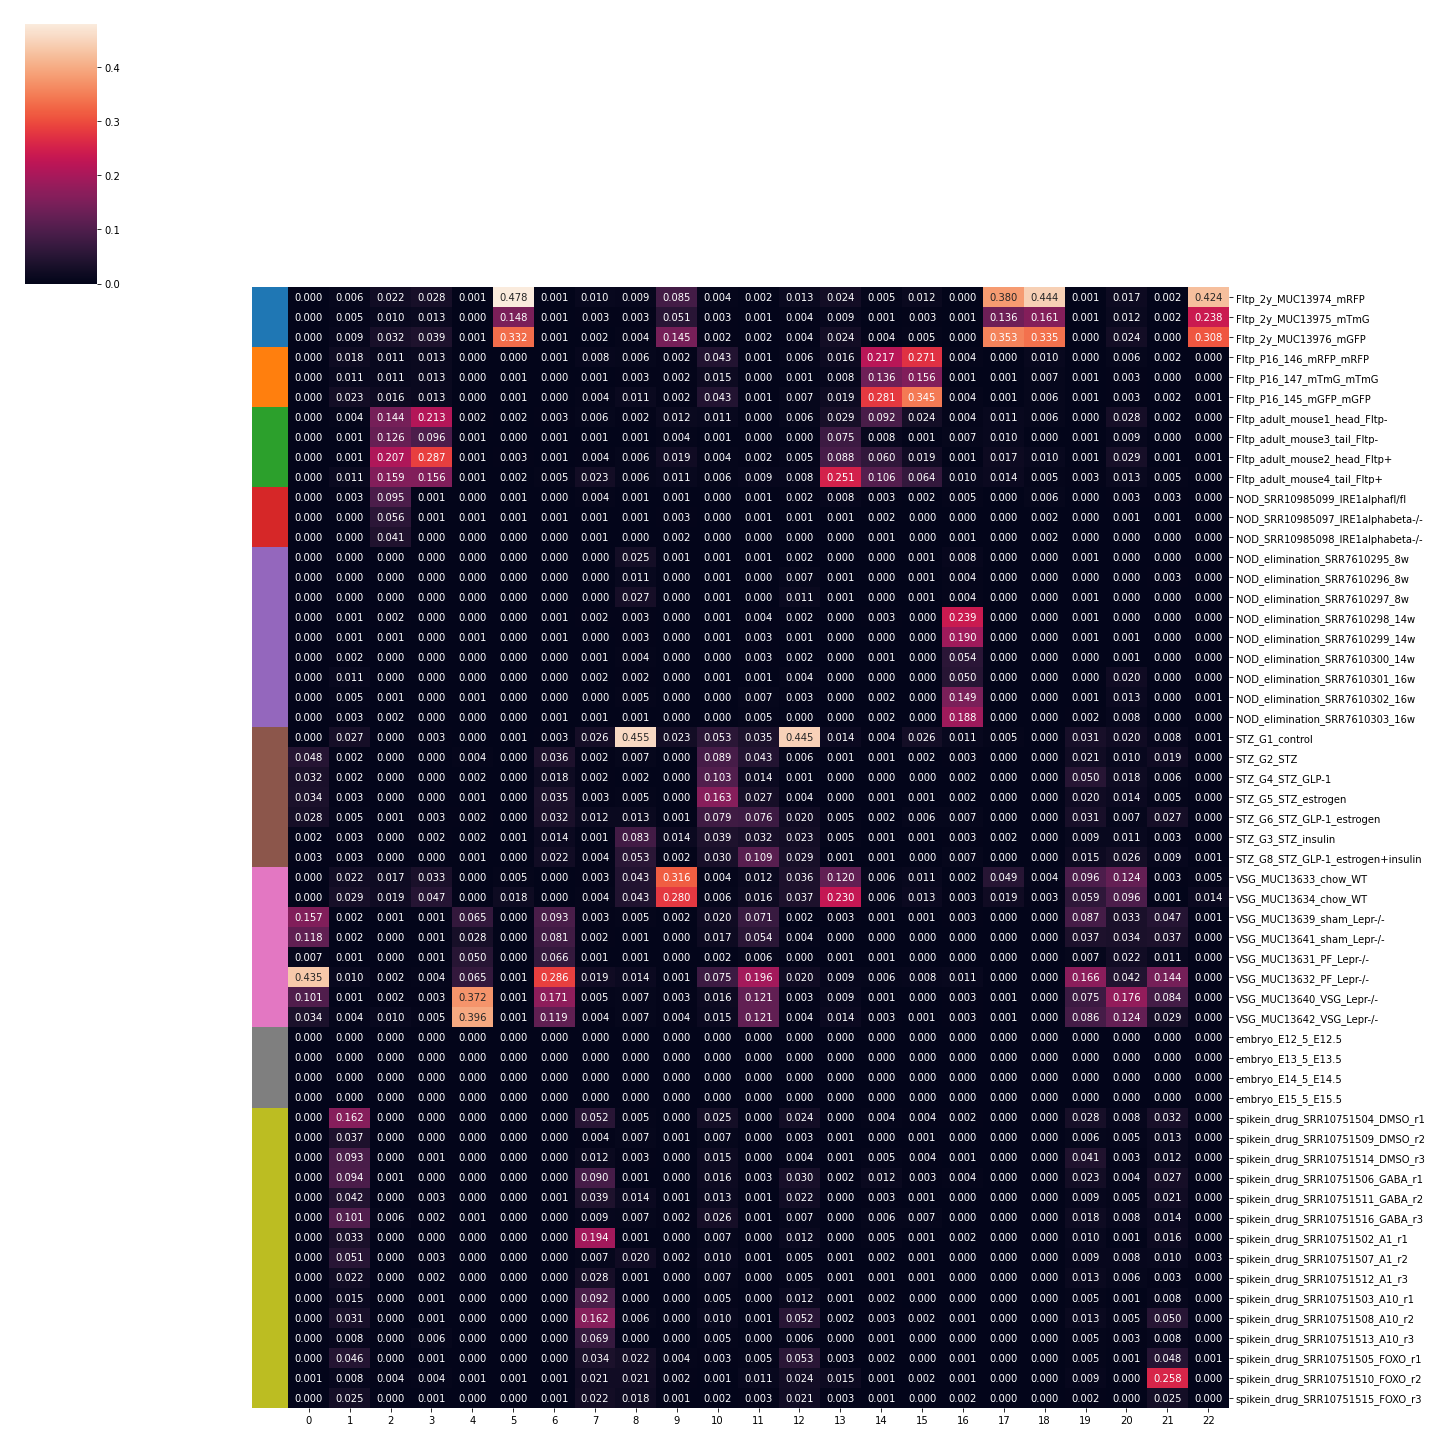

In [24]:
sb.clustermap(group_sample_ratios,row_colors=study_colors,annot=True,fmt='.3f',
             col_cluster=False,row_cluster=False,
             xticklabels=True,yticklabels=True,figsize=(20,20))

Check if cluster 9 actually has old signature and 13 young.

In [7]:
known_markers={
    'beta':['Ins1','Ins2','Nkx6-1','Pdx1'],
    'mature':['Mafa','Ucn3','Slc2a2'],
    'immature:':['Rbp4','Cd81','Mafb'],
    'old':['Trp53bp1'],
    'sex':['Prlr','Esr1','Ddx3y','Eif2s3y'],
    'T2D':['Gast','Gc','Aldh1a3','Cck','Aldob','Chgb'],
    'T1D':['B2m'],
    'mt':['mt-Nd1','mt-Co3','mt-Atp6'],
    }

{'mainplot_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'size_legend_ax': <AxesSubplot:title={'center':'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

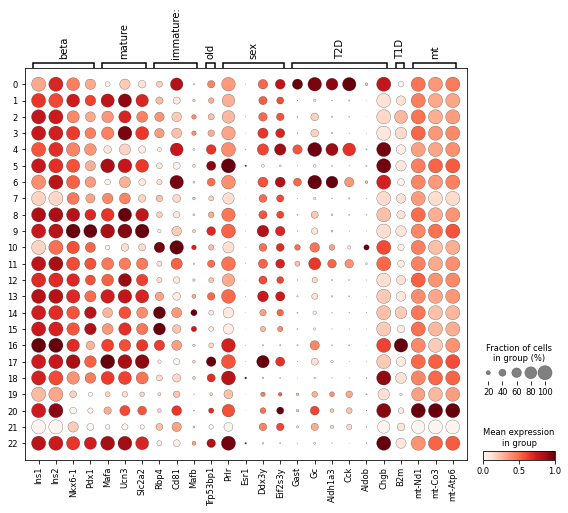

In [29]:
# Dotplot of all cells, including low quality
fig,ax=plt.subplots(
    figsize=(len([m for ms in known_markers.values() for m in ms])*0.3+2, 
             adata_rn_b.obs['leiden_r1.5'].nunique()*0.3+1.2)
)
sc.pl.dotplot(adata_rn_b,var_names=known_markers,gene_symbols='gene_symbol',
              groupby='leiden_r1.5',standard_scale='var',ax=ax,show=False)

### Finalise clusters
Merge clusters to match groups that can be interpreted.

In [31]:

# Make constant names that will not change
cluster_map={
 '0': 'T2D',
 '1': 'spikein_chem',
 '2': 'young',
 '3': 'young',
 '4': 'T2D',
 '5': 'old_female',
 '6': 'T2D',
 '7': 'spikein_chem',
 '8': 'adult',
 '9': 'old_male',
 '10': 'T2D',
 '11': 'T2D',
 '12': 'adult',
 '13': 'young',
 '14': 'young',
 '15': 'young',
 '16': 'T1D',
 '17': 'old_male',
 '18': 'old_female',
 '19': 'low_quality',
 '20': 'low_quality_highMT',
 '21': 'spikein_chem',
 '22': 'old_female'}
adata_rn_b.obs['leiden_r1.5_parsed_const']=adata_rn_b.obs['leiden_r1.5'].map(cluster_map
                                                                      ).astype('category')
# prtetty names
cluster_map={
    'young':'imm.', 
    'old_female':'agedF', 
    'old_male':'agedM', 
    'T2D':'db/db+mSTZ', 
    'spikein_chem':'chem', 
    'adult':'adult', 
    'low_quality_highMT':'lowQ-hMT', 
    'T1D':'NOD-D', 
    'low_quality':'lowQ'
}
adata_rn_b.obs['leiden_r1.5_parsed']=adata_rn_b.obs['leiden_r1.5_parsed_const'].map(cluster_map
                                                                      ).astype('category')
leiden_parsed_catgories=['imm.','adult','agedF','agedM',
                         'NOD-D','db/db+mSTZ','chem','lowQ','lowQ-hMT']
adata_rn_b.obs['leiden_r1.5_parsed']=pd.Categorical(
    values=adata_rn_b.obs['leiden_r1.5_parsed'],
    categories=leiden_parsed_catgories,
    ordered=True)

### PAGA
Analyse cluster relationships for asignemnt of challenging clusters

In [25]:
clustering='leiden_r1.5'

In [124]:
sc.tl.paga(adata_rn_b,groups=clustering)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'studyparsed_design_sample' as categorical


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


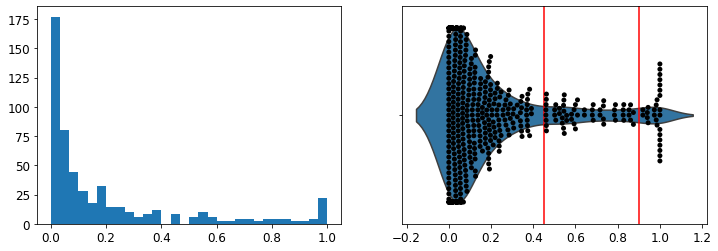

In [125]:
# Distn of PAGA connectivities
fig,axs=plt.subplots(1,2,figsize=(12,4))
paga_conn=adata_rn_b.uns['paga']['connectivities'].toarray().ravel()
a=axs[0].hist(paga_conn,bins=30)
sb.violinplot(paga_conn,ax=axs[1], inner=None)
sb.swarmplot(paga_conn,ax=axs[1],color='k')
thr=0.45
axs[1].axvline(thr,c='r')
thr1=0.9
axs[1].axvline(thr1,c='r')

In [148]:
rcParams['figure.figsize']=(5,5)

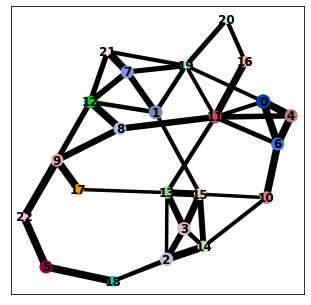

In [152]:
sc.pl.paga(adata_rn_b, color=clustering,threshold=thr)

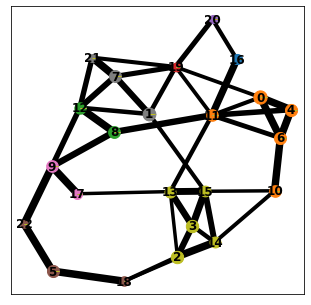

In [155]:
sc.pl._utils._set_default_colors_for_categorical_obs(adata_rn_b, clustering+'_parsed')
sc.pl.paga(adata_rn_b, color=clustering+'_parsed',threshold=thr)

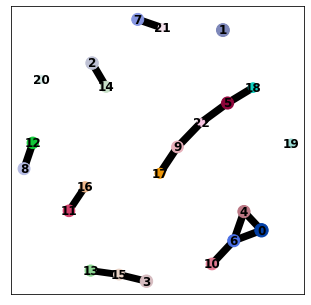

In [156]:
sc.pl.paga(adata_rn_b, color=clustering,threshold=thr1)

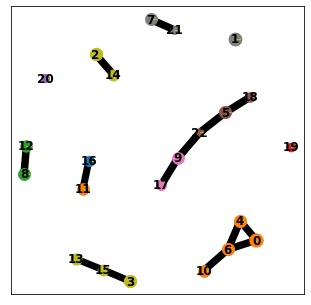

In [157]:
sc.pl.paga(adata_rn_b, color=clustering+'_parsed',threshold=thr1)

C: Indeeded, the cluster 9 is more connected with old cluster and cluster 13 with young clusters.

### Analyse finalised clusters

Proportions of each cluster in each sample, normalised by sample

In [32]:
# Ratios
group_sample_ratios=pd.DataFrame()
adata_rn_b.obs['studyparsed_design_sample']=[
    '_'.join(i) for i in 
     zip(adata_rn_b.obs.study_parsed,adata_rn_b.obs.design,adata_rn_b.obs.file)]
for (sample,hc),ratio in adata_rn_b.obs.query('study!="embryo"').\
        groupby('studyparsed_design_sample',observed=True)['leiden_r1.5_parsed'].\
        value_counts(normalize=True,sort=False).iteritems():
    group_sample_ratios.at[sample,hc]=ratio 
group_sample_ratios.fillna(0,inplace=True)    

# Add design and study info for sorting and anno
group_sample_ratios['design']=[
    adata_rn_b.obs.query('studyparsed_design_sample==@sample').design.values[0]  
    for sample in group_sample_ratios.index]
group_sample_ratios['design']=pd.Categorical(group_sample_ratios['design'],
              categories=[ 
              'E12.5','E13.5','E14.5', 'E15.5', 
                  'mRFP','mTmG','mGFP',
              'head_Fltp-','tail_Fltp-', 'head_Fltp+', 'tail_Fltp+',
              'DMSO_r1','DMSO_r2', 'DMSO_r3','GABA_r1','GABA_r2', 'GABA_r3',
                   'A1_r1','A1_r2','A1_r3','A10_r1','A10_r2', 'A10_r3',  'FOXO_r1', 'FOXO_r2', 'FOXO_r3',
              'IRE1alphafl/fl','IRE1alphabeta-/-', 
              '8w','14w', '16w',
              'control','STZ', 'STZ_GLP-1','STZ_estrogen', 'STZ_GLP-1_estrogen',
                  'STZ_insulin','STZ_GLP-1_estrogen+insulin' ,
                  'chow_WT','sham_Lepr-/-','PF_Lepr-/-','VSG_Lepr-/-',   
            ],
            ordered=True)
group_sample_ratios['study']=[
    adata_rn_b.obs.query('studyparsed_design_sample==@sample').study_parsed.values[0]  
    for sample in group_sample_ratios.index]
studies_order=adata_rn_b.uns['study_parsed_order']
group_sample_ratios['study']=pd.Categorical(
    group_sample_ratios['study'],ordered=True,
    categories=studies_order)
# Sort rows 
group_sample_ratios=group_sample_ratios.sort_values(['study','design'])
# Save study info
studies=group_sample_ratios.study.values
# Drop unused cols
group_sample_ratios.drop(['study','design'],axis=1,inplace=True)
# Sort/select columns
group_sample_ratios=group_sample_ratios[adata_rn_b.obs['leiden_r1.5_parsed'].cat.categories]

# Order columns
#group_sample_ratios=group_sample_ratios.iloc[:,
#    h.opt_order(group_sample_ratios.T,metric='correlation',method='ward')]

# Add rowcolors 

# Study
#sc.pl._utils._set_default_colors_for_categorical_obs(adata_rn_b, 'study_parsed')
study_cmap=dict(zip(adata_rn_b.obs.study_parsed.cat.categories,
                    adata_rn_b.uns['study_parsed_colors']))
study_cmap={s:study_cmap[s] for s in studies_order}
del study_cmap['embryonic']
study_colors=[study_cmap[s] for s in studies]

# Age map
study_parsed_map=dict(zip(adata_rn_b.obs.study_parsed,adata_rn_b.obs.study))
study_age_categ={
    'Fltp_2y':'2y', 
    'Fltp_adult':'3-7m', 
    'Fltp_P16':'0-1m', 
    'NOD':'1-1.5m', 
   # 'NOD_elimination':None, 
    'spikein_drug':'2-3m', 
    'VSG':'3-7m', 
    'STZ':'3-7m'}
ages_order=['0-1m','1-1.5m','1.5-2m','2-3m','3-7m','2y']
normalize = mcolors.Normalize(vmin=0,  vmax=len(ages_order)-1)
age_cmap={age:cm.viridis(normalize(idx)) for idx,age in enumerate(ages_order)}
ages=[]
for sample,study in zip(group_sample_ratios.index,studies):
    study=study_parsed_map[study]
    if study=='NOD_elimination':
        if '8w' in sample:
            age='1.5-2m'
        else:
            age='3-7m'
    else:
        age=study_age_categ[study]
    ages.append(age)
age_colors=[age_cmap[a] for a in ages]

# Perturbation map
perturbation_map={}
for sample in group_sample_ratios.index:
    if 'mSTZ' in sample and 'control' not in sample:
        p='mSTZ'
    elif 'db/db' in sample and 'WT' not in sample:
        p='db/db'
    elif 'chem' in sample and 'DMSO' not in sample:
        p='other chemical'
    elif 'NOD' in sample:
        p='NOD'
    else:
        p='none'
    perturbation_map[sample]=p
perturbation_cmap={'NOD':'#58017B','mSTZ':'#E06397','db/db':'#9A0A0A',
                   'other chemical':'#A2B308','none':'#C3C3C3'}
perturbation_colors=[perturbation_cmap[ perturbation_map[s]] for s in group_sample_ratios.index]

# Combine anno
blank=['#FFFFFF']*group_sample_ratios.shape[0]
row_anno=pd.DataFrame({'perturbation':perturbation_colors,
                       'age group':age_colors,
                      'study':study_colors,'':blank},
                      index=group_sample_ratios.index)

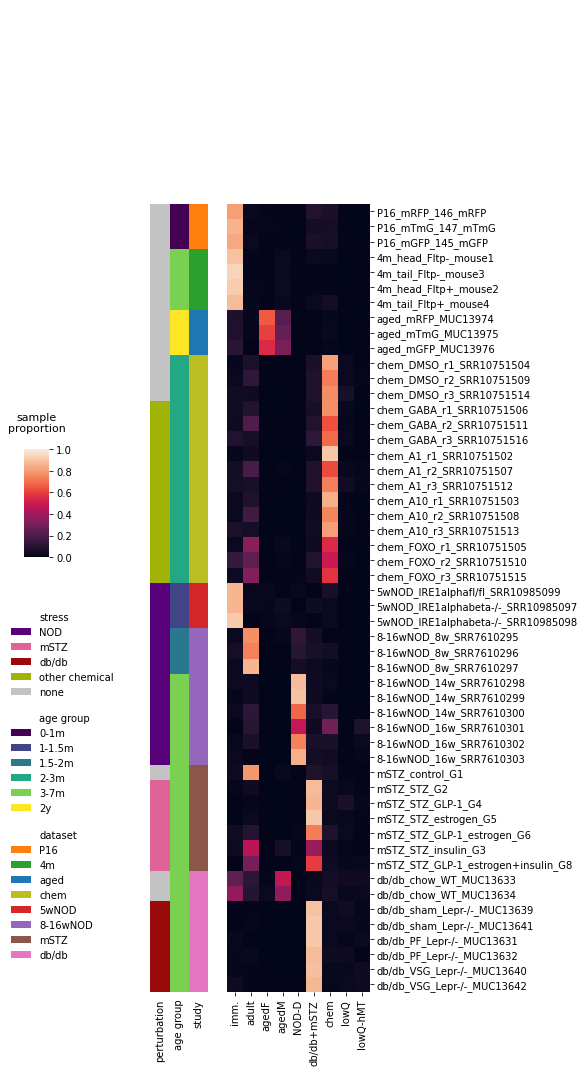

In [33]:
# Cmap
g=sb.clustermap(group_sample_ratios,row_colors=row_anno,
                #annot=True,fmt='.2f',
             col_cluster=False,row_cluster=False,
             xticklabels=True,yticklabels=True,figsize=(7,15),vmin=0,vmax=1,
               colors_ratio=0.07,cbar_pos=(-0.12,0.48,0.05,0.1))
g.cax.set_title("sample\nproportion\n",fontsize=11)
# Remove row colors tick
g.ax_row_colors.xaxis.set_ticks_position('none') 

# Add legend for row colors
legend_elements = [ Patch(alpha=0,label='stress')]+[
     Patch(facecolor=perturbation_cmap[s],label=s) 
    for s in ['NOD','mSTZ','db/db','other chemical','none']
]+[ Patch(alpha=0,label='\nage group')]+[
     Patch(facecolor=c,label=s) for s,c in age_cmap.items()
]+[ Patch(alpha=0,label='\ndataset')]+[
     Patch(facecolor=c,label=s) for s,c in study_cmap.items()
]
ax=g.fig.add_subplot(223)
ax.axis('off')
ax.legend(handles=legend_elements, bbox_to_anchor=(0.2,0.79),frameon=False)

# Save
plt.savefig(path_fig+'heatmap_beta_CLcoarse_samples.png',dpi=300,bbox_inches='tight')

#### Clusters on UMAP
Clusters on UMAP. Note: The here used embeeding requires first to run notebook for optimised beta cell UMAP. The UMAP can be replaced by defualt scanpy UMAP.

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'studyparsed_design_sample' as categorical


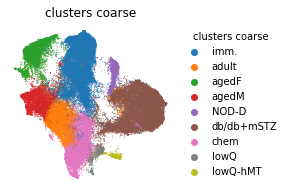

In [34]:
fig,ax=plt.subplots(figsize=(3,3))
np.random.seed(0)
random_indices=np.random.permutation(list(range(adata_rn_b.shape[0])))
sc.pl.embedding(adata_rn_b[random_indices,:],'X_umap_opt',color='leiden_r1.5_parsed',s=3,ax=ax,show=False,
          title='clusters coarse',frameon=False)
ax.legend_.set_title('clusters coarse')
plt.savefig(path_fig+'umap_beta_CLcoarse_eopt.png',dpi=300,bbox_inches='tight')

No low quality clusters

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'studyparsed_design_sample' as categorical


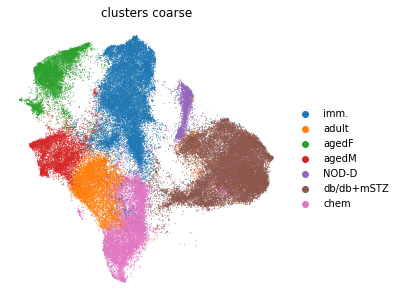

In [35]:
#Same as above but remove loq quality 
fig,ax=plt.subplots(figsize=(5,5))
np.random.seed(0)
subset=~adata_rn_b.obs['leiden_r1.5_parsed_const'].str.startswith('low_quality')
random_indices=np.random.permutation(list(range(adata_rn_b[subset,:].shape[0])))
sc.pl.embedding(adata_rn_b[subset,:][random_indices,:],'X_umap_opt',
           color='leiden_r1.5_parsed',s=3,ax=ax,show=False,
          title='clusters coarse',frameon=False, )
plt.savefig(path_fig+'umap_beta_CLcoarse_nolowQ_eopt.png',dpi=300,bbox_inches='tight')

Annotated clusters without low quality

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'studyparsed_design_sample' as categorical


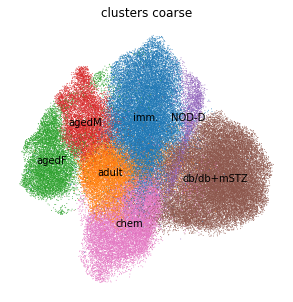

In [36]:
#Same as above but remove loq quality and annotate
fig,ax=plt.subplots(figsize=(5,5))
np.random.seed(0)
subset=~adata_rn_b.obs['leiden_r1.5_parsed_const'].str.startswith('low_quality')
random_indices=np.random.permutation(list(range(adata_rn_b[subset,:].shape[0])))
sc.pl.umap(adata_rn_b[subset,:][random_indices,:],
           color='leiden_r1.5_parsed',s=3,ax=ax,show=False,
          title='clusters coarse',frameon=False, 
           legend_loc='on data',legend_fontweight ='normal')
plt.savefig(path_fig+'umap_beta_CLcoarse_nolowQ_anno.png',dpi=300,bbox_inches='tight')

In [37]:
# N cells per cl
adata_rn_b.obs['leiden_r1.5_parsed_const'].value_counts()

T2D                   30382
young                 24975
spikein_chem          14117
adult                 10091
old_female             9070
old_male               7813
T1D                    2913
low_quality            1593
low_quality_highMT     1189
Name: leiden_r1.5_parsed_const, dtype: int64

### Save clusters

In [38]:
# Extra info to save for plotting
adata_rn_b.uns['leiden_r1.5_parsed_order']=\
    list(adata_rn_b.obs['leiden_r1.5_parsed'].cat.categories)
sc.pl._utils._set_default_colors_for_categorical_obs(adata_rn_b, 'leiden_r1.5_parsed')

In [39]:
if True:
    h.update_adata(
            adata_new=adata_rn_b, path=path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad',
            io_copy=False,
            add=[
                ('obs',True,'leiden_r1.5_parsed','leiden_r1.5_parsed'),
                ('obs',True,'leiden_r1.5_parsed_const','leiden_r1.5_parsed_const'),
                ('uns',True,'leiden_r1.5_parsed_order','leiden_r1.5_parsed_order'),
                ('uns',True,'leiden_r1.5_parsed_colors','leiden_r1.5_parsed_colors'),
            ],rm=None)

## Markers

To make selection robus use as markers the intersection of per-study DEs for each subtype (cell cluster). For each cluster use samples of a study that have at least 20% of cells in that cluster (cell selection per sample, DE per study). Then compare this study-cluster cell group to all other groups that do not come from the same cluster. At the end select as markers those that are DE for all comparisons of that cluster (e.g. in all involved studies vs all other clusters).

Do not involve embryo dataset (too little beta cells) and low quality clusters.

### DE
Cluster-study group agains all other cluster-studies groups that do not come from the same cluster.

In [13]:
adata_rn_b.obs['study_parsed_const']=adata_rn_b.obs['study'].map(
{'embryo':'embryo',
 'Fltp_P16':'postnatal',
 'Fltp_adult':'young_adult',
 'Fltp_2y':'old',
 'spikein_drug':'spikein_chem',  
 'NOD':'NOD_young',
 'NOD_elimination':'NOD_progression',
 'STZ':'STZ',
 'VSG':'dbdb'})

In [14]:
# Make study-subtype clusters containing samples that have 
# large enough proportion of cells in that subtype
thr=0.2
adata_rn_b.obs['de_cluster']=np.nan
study_n_cl_de={}
for study_parsed in [s for s in adata_rn_b.obs.study_parsed_const.unique() if s!='embryo']:
    # Sample (of study) ratio per cluster
    n=adata_rn_b.obs.query('study_parsed_const==@study_parsed').\
        groupby('file',observed=True)['leiden_r1.5_parsed_const'].\
        value_counts(normalize=True,dropna=True)
    n=n[n>=thr].reset_index().rename({'level_1':'cluster'},axis=1)
    # Make group from samples with high enough subtype ratios, excluding low quality
    study_cls=set()
    for idx,data in n.iterrows():
        cluster=data['cluster']
        if 'low_quality' not in cluster:
            file=data['file']
            cells=adata_rn_b.obs.query(
                'study_parsed_const==@study_parsed & file==@file & `leiden_r1.5_parsed_const`==@cluster'
                ).index
            adata_rn_b.obs.loc[cells,'de_cluster']=study_parsed+':'+cluster
            study_cls.add(cluster)
    print('Study %s is in %i clusters'%(study_parsed,len(study_cls)))
    study_n_cl_de[study_parsed]=len(study_cls)
adata_rn_b.obs['de_cluster']=adata_rn_b.obs['de_cluster'].astype('category')

Study old is in 2 clusters
Study young_adult is in 1 clusters
Study postnatal is in 1 clusters
Study NOD_young is in 1 clusters
Study NOD_progression is in 3 clusters
Study spikein_chem is in 2 clusters
Study dbdb is in 3 clusters
Study STZ is in 2 clusters


In [14]:
# Remove previous DE results
for key in list(adata_rn_b.uns.keys()):
    if key.startswith('rank_genes_'):
        del adata_rn_b.uns[key]

In [15]:
# List of all clusters
clustering='de_cluster'
clusters=list([cl for cl in adata_rn_b.obs[clustering].cat.categories ])

In [8]:
# Get DE genes
for idx1 in range(0,len(clusters)-1):
    for idx2 in range(idx1+1,len(clusters)):
        cl1=clusters[idx1]
        cl2=clusters[idx2]
        # Compare only cell groups not from same subtype
        if cl1.split(':')[1]!=cl2.split(':')[1]:
            print(cl1,cl2)
            # Remove genes expressed in less than 25% cells in both groups individually
            mask_cell1=adata_rn_b.obs[clustering]==cl1
            mask_cell2=adata_rn_b.obs[clustering]==cl2
            min_expr_ratio=0.25
            mask_gene=np.logical_or(
                np.asarray(
                    (adata_rn_b[mask_cell1,:].X>0).sum(axis=0)).ravel()>=(
                    mask_cell1.sum()*min_expr_ratio),
                np.asarray(
                    (adata_rn_b[mask_cell2,:].X>0).sum(axis=0)).ravel()>=(
                    mask_cell2.sum()*min_expr_ratio))
            adata_temp=adata_rn_b[:,mask_gene].copy()

            key_added='rank_genes_'+cl1+'_vs_'+cl2
            sc.tl.rank_genes_groups(adata_temp, groupby=clustering,
                              use_raw=False, groups=[cl1], reference=cl2, 
                              rankby_abs=True, method='t-test',
                              key_added=key_added)
            adata_rn_b.uns[key_added]=adata_temp.uns[key_added]
            del adata_temp

NOD_progression:T1D NOD_progression:adult
NOD_progression:T1D NOD_progression:spikein_chem
NOD_progression:T1D NOD_young:young
NOD_progression:T1D STZ:T2D
NOD_progression:T1D STZ:adult
NOD_progression:T1D dbdb:T2D
NOD_progression:T1D dbdb:old_male
NOD_progression:T1D dbdb:young
NOD_progression:adult postnatal:young
NOD_progression:adult spikein_chem:spikein_chem
NOD_progression:adult young_adult:young
NOD_progression:spikein_chem NOD_young:young
NOD_progression:spikein_chem STZ:T2D
NOD_progression:spikein_chem STZ:adult
NOD_progression:spikein_chem dbdb:T2D
NOD_progression:spikein_chem dbdb:old_male
NOD_progression:spikein_chem dbdb:young
NOD_progression:spikein_chem old:old_female
NOD_progression:spikein_chem old:old_male
NOD_progression:spikein_chem postnatal:young
NOD_progression:spikein_chem spikein_chem:adult
NOD_progression:spikein_chem young_adult:young
NOD_young:young STZ:T2D
NOD_young:young STZ:adult
NOD_young:young dbdb:T2D
NOD_young:young dbdb:old_male
NOD_young:young old:ol

In [9]:
# Save whole DE result
pkl.dump({de:adata_rn_b.uns[de] for de in adata_rn_b.uns.keys() if 'rank_genes_' in de},
            open(path_save+'markersCL_leiden_r1.5_parsed_const_study.pkl','wb'))

In [16]:
# Reload
#for de,data in pkl.load(open(path_save+'markersCL_leiden_r1.5_parsed_const_study.pkl','rb')).items():
#    adata_rn_b.uns[de]=data

### Analyse DE
How many markers we get across clusters and studies.

In [17]:
# Markers OvR for all studies of cluster
up_cls={}
padj=0.1
des=[de.replace('rank_genes_','').split('_vs_') for de in adata_rn_b.uns.keys()
    if 'rank_genes_' in de]
categories=[c for c in adata_rn_b.obs[clustering].cat.categories]
n_comp=[]
n_de=[]
n_de_study=[]
n_de_study_cl=[]
n_de_study_cl_ambient=[]
for cl in set([c.split(':')[1] for c in categories]):
    print('*** CL:',cl)
    de_cl=[]
    # Get de tests that contain cl, 
    # make sure to add prefix ':' as some cl and stuy names overlap
    des_cl=[de for de in des if ':'+cl in de[0] or  ':'+cl in de[1]]
    print('N comp:',len(des_cl))
    n_comp.append(len(des_cl))
    for de in des_cl:
        # Get up DE genes
        if ':'+cl in de[0]:
            # As test group - positive lfc is up
            lfc_scale=1
            study_cl=de[0].split(':')[0]
            group_against=de[1]
        else:
            # As ref group - positive lfc is down
            lfc_scale=-1
            study_cl=de[1].split(':')[0]
            group_against=de[0]
        de_name=f'rank_genes_%s_vs_%s'%tuple(de)
        de_cl.append(pd.DataFrame({'name':adata_rn_b.uns[de_name]['names'][de[0]],
              'padj':adata_rn_b.uns[de_name]['pvals_adj'][de[0]],
              'logFC':adata_rn_b.uns[de_name]['logfoldchanges'][de[0]]*lfc_scale,
               'comparison':de_name.replace('rank_genes_',''),
               'study':study_cl,
                'cl_against' :group_against.split(':')[1],      
                'study_against' :group_against.split(':')[0],      
                }))
    # Get significant genes in all compared cl and save smallest lFC per gene
    de_cl=pd.concat(de_cl)
    up_cl=de_cl.query('padj<@padj & logFC>0')
    up_summary=up_cl.groupby('name')
    up_all=up_summary.size()==len(des_cl)
    # N de per study across all cts
    for study in up_cl['study'].unique():
        n=(up_cl.query('study==@study').groupby('name').size()==len(
            [de for de in des_cl if study+':'+cl == de[0] or  study+':'+cl == de[1]])).sum()
        n_de_study.append({'cl':cl,'study':study,'n_de':n})
    # N de per study counting in how many cts it is signif
    for study in de_cl['study'].unique():
        # How many genes are DE in that many cts; 
        # another case for disregaridng potentially ambient ones
        n_cl_de=defaultdict(lambda:0)
        n_cl_de_ambient=defaultdict(lambda:0)
        for gene,data in de_cl.query('study==@study').groupby('name'):
            # Check for gene in which cls it is DE for all studies in that cl
            n_cl=0
            n_cl_ambient=0
            for cl_agains,data_sub in data.groupby('cl_against'):
                if ((data_sub.padj<padj).values & (data_sub.logFC>0).values).all():
                    n_cl+=1
                    if genes_info.at[gene,'rel_maxscl_beta_expr_cl']>0.7:
                        n_cl_ambient+=1
            if n_cl>0: # Do not save markers not DE in 0 clusters
                n_cl_de[n_cl]+=1
            if n_cl_ambient>0: # Do not save markers not DE in 0 clusters
                n_cl_de_ambient[n_cl_ambient]+=1
        n_de_study_cl.append(pd.DataFrame(
            {'study':[study]*len(n_cl_de),'cl':[cl]*len(n_cl_de),
             'n_cl':n_cl_de.keys(), 'n_genes':n_cl_de.values()}))
        n_de_study_cl_ambient.append(pd.DataFrame(
            {'study':[study]*len(n_cl_de_ambient),'cl':[cl]*len(n_cl_de_ambient),
             'n_cl':n_cl_de_ambient.keys(), 'n_genes':n_cl_de_ambient.values()}))
    # Add for lFC filtering
    up_cl=up_summary.apply(lambda x: abs(x.logFC).min())[up_all]
    up_cl.name='logFC'
    up_cl=pd.DataFrame(up_cl)
    up_cl.sort_values('logFC',ascending=False,inplace=True)
    up_cl['gene_symbol']=adata_rn_b.var.loc[up_cl.index,'gene_symbol']
    up_cls[cl]=up_cl
    print(cl, 'N up overall:',len(up_cl))
    n_de.append(len(up_cl))
n_de_study=pd.DataFrame(n_de_study)
n_de_study_cl=pd.concat(n_de_study_cl)
n_de_study_cl_ambient=pd.concat(n_de_study_cl_ambient)

*** CL: young
N comp: 44
young N up overall: 3
*** CL: T2D
N comp: 26
T2D N up overall: 339
*** CL: old_male
N comp: 26
old_male N up overall: 87
*** CL: adult
N comp: 36
adult N up overall: 1
*** CL: spikein_chem
N comp: 26
spikein_chem N up overall: 2
*** CL: T1D
N comp: 14
T1D N up overall: 237
*** CL: old_female
N comp: 14
old_female N up overall: 618


C: Rising padj to 0.25 does not help to get more genes in adult and young.

Compare N markers obstained per cluster and N comparisons that were made (more if there are more studies in the cluster).

Text(0, 0.5, 'N markers')

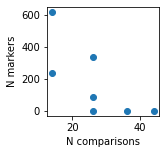

In [12]:
# Compare N comparisons vs N markers
rcParams['figure.figsize']=(2,2)
plt.scatter(n_comp,n_de)
plt.xlabel('N comparisons')
plt.ylabel("N markers")

How many markers were obtained per study for each cluster

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


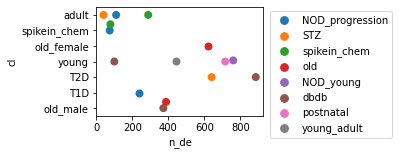

In [13]:
# Explore how studies lead to De per cluster
rcParams['figure.figsize']=(3,2)
sb.swarmplot(y='cl',x='n_de',hue='study',data=n_de_study,s=8)
plt.legend(bbox_to_anchor=(1.01, 1.01))

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


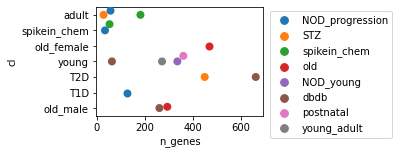

In [22]:
# Explore how studies lead to De per cluster
# Subset to only genes taht would be retained after ambient filtering
rcParams['figure.figsize']=(3,2)
n_other_cl=len([cl for cl in adata_rn_b.obs['leiden_r1.5_parsed_const'].unique()
            if 'low_quality' not in cl])-1
sb.swarmplot(y='cl',x='n_genes',hue='study',
             data=n_de_study_cl_ambient.query('n_cl==@n_other_cl'),s=8)
plt.legend(bbox_to_anchor=(1.01, 1.01))

Per study how many genes do we get if we want DE against that many cl.

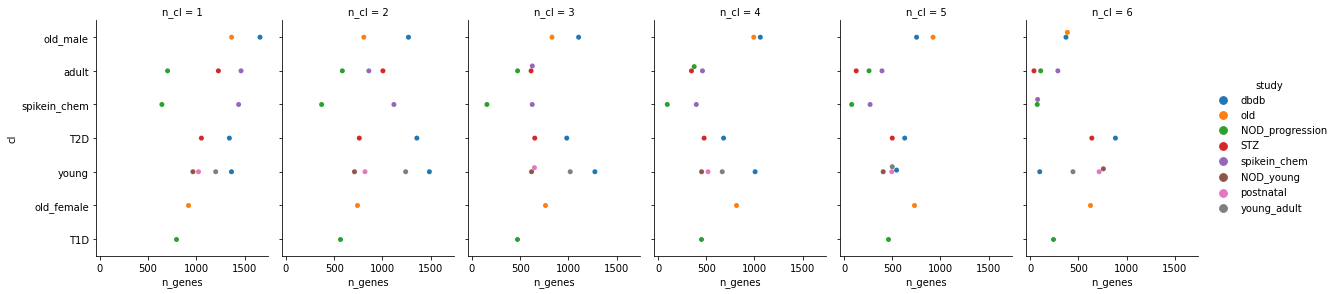

In [22]:
sb.catplot(x="n_genes", y="cl",hue="study", col="n_cl",
                data=n_de_study_cl, kind="swarm",
                height=4, aspect=.7);

In how many clusters is a study

In [78]:
print('N cl in which the study is:\n',study_n_cl_de)

N cl in which the study is:
 {'old': 2, 'young_adult': 1, 'postnatal': 1, 'NOD_young': 1, 'NOD_progression': 3, 'spikein_chem': 2, 'dbdb': 3, 'STZ': 2}


C: It seems that low N markers may not be solely due to using intersection, but also due to some clusters also having less markers when selecting them on per-study level, at least for some studies (limiting factor). It does not seem that this would be solely due to some studies being in more clusters (thus better correcting batch effects).

C: Reason for young having less markers could be dbdb (and spikein) as they have cells in cl 13 which clusters with young, but has somwewhat different expression. It seems that when reducing requirement for markers to be DE against all clusters vs n-1 clusters already increases N markers for that study.

### Extract markers

For each ct:
- Extract intersection of interactions agains all other cts (consistent across studies)
- Sort by min lFC overall

In [18]:
# Extract marker info for each cl
comparisons=[k for k in adata_rn_b.uns.keys() 
             if k.startswith('rank_genes_')]
ress={}
clusters_with_markers=[cl for cl in adata_rn_b.obs['leiden_r1.5_parsed_const'].cat.categories 
            if 'low_quality' not in cl]
for cl in clusters_with_markers:
    # Extract relevant comparisons for each cl
    comparisons_cl=[]
    for comparison in comparisons:
        g1,g2=comparison.replace('rank_genes_','').split('_vs_')
        study1,cl1=g1.split(':')
        study2,cl2=g2.split(':')
        if cl1==cl:
            comparisons_cl.append({'comparison':comparison,'cl_against':cl2,
                                   'study':study1,'study_against':study2,
                                   'direction':1,'de_key':g1})
        elif cl2==cl:
            comparisons_cl.append({'comparison':comparison,'cl_against':cl1,
                                   'study':study2,'study_against':study1,
                                  'direction':-1,'de_key':g1})
    comparisons_cl=pd.DataFrame(comparisons_cl)
    # Min of oriented lfc across all comparisons
    lfc_min=pd.concat([pd.DataFrame({
        'lfc':adata_rn_b.uns[comparison]['logfoldchanges'][de_key]*direction,
         'name':adata_rn_b.uns[comparison]['names'][de_key]})
             for comparison,direction,de_key in 
             zip(comparisons_cl.comparison,comparisons_cl.direction,comparisons_cl.de_key)]
         ).groupby('name').lfc.min().rename('min_lfc')
    res=pd.DataFrame(lfc_min)
    res['n_cl_de']=0
    # N cts where gene is DE in  all comparisons
    for cl_against,data in comparisons_cl.groupby('cl_against'):
        n_comp=data.shape[0]
        # Which genes are DE in all comparisons agains specific cl
        de=pd.DataFrame(pd.concat([pd.DataFrame({
        'lfc':adata_rn_b.uns[comparison]['logfoldchanges'][de_key]*direction,
        'padj':adata_rn_b.uns[comparison]['pvals_adj'][de_key],
         'name':adata_rn_b.uns[comparison]['names'][de_key]})
             for comparison,direction,de_key in 
             zip(data.comparison,data.direction,data.de_key)]
         ).query('padj<0.1 & lfc>0'
                ).groupby('name').size().rename('n')).query('n==@n_comp').index
        # Add that de against another cluster
        res.loc[de,'n_cl_de']+=1
    # Add rel expression
    res['beta_rel_expr']=genes_info.loc[res.index,'rel_maxscl_beta_expr_cl']
    # Sort genes
    ress[cl]=res.sort_values(['n_cl_de','min_lfc'],ascending=False)

In [20]:
# Save whole parsed DE results
pkl.dump(ress,open(path_save+'markersCLparsed_leiden_r1.5_parsed_const_study.pkl','wb'))

N markers

In [48]:
# N DE against all cl
print('N DE against all cl:')
for cl,res in ress.items():
    print(cl,res.query('n_cl_de==6').shape[0])

N DE against all cl:
T1D 237
T2D 339
adult 1
old_female 618
old_male 87
spikein_chem 2
young 3


N markers if we did not require to be DE against all other clusters (only some of them).

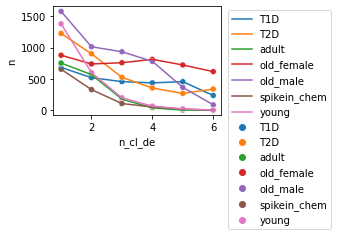

In [148]:
data=[]
for cl,res in ress.items():
    res=res.copy()
    res=res.groupby('n_cl_de').size().rename('n').reset_index()
    res['cl']=cl
    data.append(res.query('n_cl_de>0'))
data=pd.concat(data)
sb.scatterplot(x='n_cl_de',y='n',hue='cl',data=data)
sb.lineplot(x='n_cl_de',y='n',hue='cl',data=data)
plt.legend(bbox_to_anchor=(1.01,1.01))

C: Lowering n clusters requirement against which marker is DE does not increase N selected markers much. Also, this would be less meaningful as we want cluster-specific markers.

### Analyse selected markes
- How do studies contribute to marker reliability
- Expression comparison.

N studies per cluster

In [159]:
print('N studies per cl')
display(pd.Series(adata_rn_b.obs['de_cluster'].dropna().unique()
         ).apply(lambda x: x.split(':')[1]).value_counts())

N studies per cl


young           4
adult           3
old_male        2
spikein_chem    2
T2D             2
old_female      1
T1D             1
dtype: int64

C: Old female markers may be less reliable as we have only 1 study there

Make paper ready figure of N markers would be selected per study. Make sure to use same procedure as for plotted markers - e.g. using ambient.

<ipython-input-49-f166df1186e0>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster']=data.cl.map(cl_map).copy()
<ipython-input-49-f166df1186e0>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename({'n_genes':'N DE'},axis=1,inplace=True)


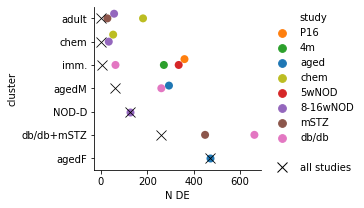

In [49]:
# Explore how studies lead to De per cluster
# Subset to only genes taht would be retained after ambient filtering
fig,ax=plt.subplots(figsize=(3,3))
# how many genes were selected at the end across all studies
# Sort by N
n_other_cl=len([cl for cl in adata_rn_b.obs['leiden_r1.5_parsed_const'].unique()
            if 'low_quality' not in cl])-1
data_deall=pd.DataFrame({cl:data.query('n_cl_de==@n_other_cl and beta_rel_expr>0.7').shape[0] 
                        for cl,data in ress.items()},index=['N DE']
                     ).T.reset_index().rename({'index':'cluster'},axis=1
                                             ).sort_values('N DE')
# De per study agains all cl and not ambient
data=n_de_study_cl_ambient.query('n_cl==@n_other_cl')
# Mark how many genes were selected at the end across all studies
g=sb.scatterplot(x='N DE',y='cluster',
    data=data_deall, ax=ax,s=100,marker='x',c=['#000000'])
crosses=g.get_children()
# Parse cl names
cl_map=dict(zip(adata_rn_b.obs['leiden_r1.5_parsed_const'],
                         adata_rn_b.obs['leiden_r1.5_parsed']))
data['cluster']=data.cl.map(cl_map).copy()
data_deall['cluster']=data_deall['cluster'].map(cl_map)
data.rename({'n_genes':'N DE'},axis=1,inplace=True)
# Order y same as data above - otherwise plot is corrupted
cl_position=dict(zip(data_deall.cluster,
                     range((data_deall.cluster.nunique()))))
data = data.sort_values('cluster',key=lambda x:x.map(cl_position))

# Rename studies
study_map={sc:adata_rn_b.obs.query('study_parsed_const==@sc')['study_parsed'][0] 
                          for sc in data.study.unique()}
data['study']=data['study'].map(study_map)
data['study']=pd.Categorical(
    values=data['study'],ordered=True,
    categories=[s for s in adata_rn_b.uns['study_parsed_order'] if s in data['study'].unique()])

sb.swarmplot(y='cluster',x='N DE',hue='study',
             data=data,s=8,ax=ax,
             palette=dict(zip(adata_rn_b.obs['study_parsed'].cat.categories,
                              adata_rn_b.uns['study_parsed_colors'])))

# Reset xlim as else set based on last plotted (combined) - thus cuts data out
ax.set_xlim(-30,data['N DE'].max()+30)

# Legend
patches,labels=ax.get_legend_handles_labels()
# Add spacer
patches.append(Line2D([0],[0],marker='o', color='k',  markerfacecolor='none', 
                        markersize=0,markeredgecolor='none',lw=0)) 
labels.append('')
# Mark overlap
patches.append(Line2D([0],[0],marker='x', color='k',  markerfacecolor='none', 
                        markersize=10,markeredgecolor='k',lw=0,)) 
labels.append('all studies')
ax.legend(handles=patches,labels=labels,bbox_to_anchor=(1.01, 1.02),title='study',
          frameon=False)

# Seethrough
ax.set(facecolor = (0,0,0,0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# make sure corsses are on top
for c in crosses:
    c.set_zorder(1000)
    
plt.savefig(path_fig+'scatter_beta_CLcoarse_newmarkers_studyN.png',dpi=300,bbox_inches='tight')

In [21]:
# Reload ress
ress=pkl.load(open(path_save+'markersCLparsed_leiden_r1.5_parsed_const_study.pkl','rb'))

Save marker DE table for paper

In [50]:
# Save De summaries in excel format for paper with parsed ct names
writer = pd.ExcelWriter(path_save+'markersCLparsed_leiden_r1.5_parsed_const_study.xlsx',
                        engine='xlsxwriter') 
for ct,data in ress.items():
    # Add data to De summary
    data=data.copy()
    ct=adata_rn_b.obs.query('`leiden_r1.5_parsed_const`==@ct')['leiden_r1.5_parsed'][0]
    data.drop('beta_rel_expr',axis=1,inplace=True)
    data['rel_beta_expr']=genes_info.loc[data.index,'rel_maxscl_beta_expr_cl'].values
    data[['mean_expr_in_expr_cells']]= genes_info.loc[data.index, ['mean_expr_in_expr_cells']]
    data['gene_symbol']=var.loc[data.index,'gene_symbol']
    data.to_excel(writer, sheet_name=str(ct).replace('/','').replace('+','&'))   
writer.save()

Plot final marker selection as dotplot

In [9]:
# Get markers for plotting
# Remove some known invalid genes
eids_remove=[eid for eid,g in zip(adata_rn_b.var_names,adata_rn_b.var.gene_symbol) 
             if g.startswith('Hba-') or g.startswith('Hbb-')]
n_cl=len([c for c in adata_rn_b.obs['leiden_r1.5_parsed_const'].unique() 
      if not c.startswith('low_quality')])
n_cl_de_all=n_cl-1
plot_markers={}
plot_markers_eid={}
for group,data in ress.items():
    group_new=adata_rn_b.obs.query('`leiden_r1.5_parsed_const`==@group')['leiden_r1.5_parsed'].unique()[0]
    plot_markers_eid[group_new]=data[~data.index.isin(eids_remove)].query(
        'beta_rel_expr>0.7 & n_cl_de==@n_cl_de_all' ).head(5).index
    plot_markers[group_new]=adata_rn_b.var.loc[plot_markers_eid[group_new],
        'gene_symbol'].values.to_list()
# Sort markers to plot
plot_markers={g:plot_markers[g] 
              for g in adata_rn_b.obs['leiden_r1.5_parsed'].cat.categories 
              if g in plot_markers}
plot_markers_eid={g:plot_markers_eid[g] 
              for g in adata_rn_b.obs['leiden_r1.5_parsed'].cat.categories 
              if g in plot_markers_eid}

In [52]:
# Save selected markers
pkl.dump(plot_markers_eid,
            open(path_save+'markersCLparsed_leiden_r1.5_parsed_const_study_selected.pkl','wb'))

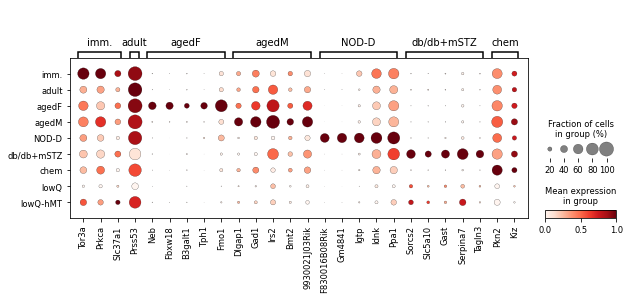

In [10]:
# [0,1] scaling on groups
fig,ax=plt.subplots(
    figsize=(len([m for ms in plot_markers.values() for m in ms])*0.3+2, 
             adata_rn_b.obs['leiden_r1.5_parsed'].nunique()*0.3+1.2)
)
sc.pl.dotplot(adata_rn_b,var_names=plot_markers,gene_symbols='gene_symbol',
              groupby='leiden_r1.5_parsed',standard_scale='var',ax=ax,show=False, 
              var_group_rotation=0)
plt.savefig(path_fig+'dotplot_beta_CLcoarse_newmarkers.png',dpi=300,bbox_inches='tight')

Dotplot per study-cluster

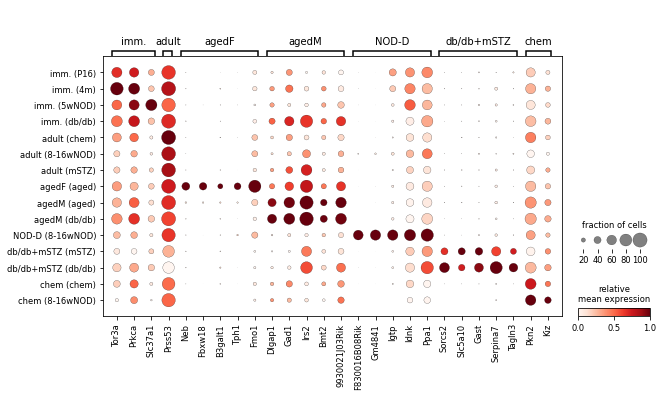

In [16]:
# Dotplot showing marker expression per cluster and study
adata_temp=adata_rn_b[~adata_rn_b.obs['de_cluster'].isna(),:].copy()
cl_map=dict(zip(adata_rn_b.obs['leiden_r1.5_parsed_const'],
                adata_rn_b.obs['leiden_r1.5_parsed']))
adata_temp.obs['cluster_study']=[
    cl_map[c.split(':')[1]]+' ('+\
    adata_rn_b.obs.study_parsed[adata_rn_b.obs['study_parsed_const']==c.split(':')[0]][0]+')' 
    for c in adata_temp.obs['de_cluster']]
# reorder categories to match cluster and study order
adata_temp.obs['study_parsed']=pd.Categorical(
    values=adata_temp.obs['study_parsed'],
    categories=adata_rn_b.uns['study_parsed_order'],ordered=True)
cluster_order=adata_temp.obs[['leiden_r1.5_parsed','study_parsed','cluster_study']].\
    drop_duplicates(). sort_values(['leiden_r1.5_parsed','study_parsed']).cluster_study.values
adata_temp.obs['cluster_study']=pd.Categorical(
    values=adata_temp.obs['cluster_study'],
    categories=cluster_order,ordered=True)
fig,ax=plt.subplots(
    figsize=(len([m for ms in plot_markers.values() for m in ms])*0.3+2, 
             adata_temp.obs['cluster_study'].nunique()*0.3+1.2)
)
sc.pl.dotplot(adata_temp,var_names=plot_markers,gene_symbols='gene_symbol',
              groupby='cluster_study',standard_scale='var',ax=ax,show=False,
              size_title='fraction of cells',
              colorbar_title='relative\nmean expression', 
              var_group_rotation=0)
plt.savefig(path_fig+'dotplot_beta_CLcoarse_newmarkers_perstudy.png',dpi=300,bbox_inches='tight')
del adata_temp

## Cluster identity confirmation
Plots for paper.

### Known markers

In [17]:
known_markers={
    'beta':['Ins1','Ins2','Nkx6-1','Pdx1'],
    'imm.':['Rbp4','Cd81','Mafb'],
    'mature':['Mafa','Ucn3','Slc2a2'],
    'aged':['Cdkn2a','Trp53bp1'], 
    'T1D':['B2m'],
    'T2D':['Gast','Gc','Aldh1a3','Cck','Aldob','Chgb'],
    }

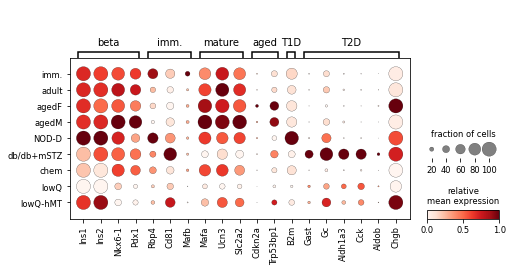

In [21]:
# Markers
fig,ax=plt.subplots(
    figsize=(len([g for gs in known_markers.values() for g in gs])*0.3+2, 
             adata_rn_b.obs['leiden_r1.5_parsed'].nunique()*0.3+1.2)
)
sc.pl.dotplot(adata_rn_b,var_names=known_markers,gene_symbols='gene_symbol',
              size_title='fraction of cells',
              colorbar_title='relative\nmean expression',
              groupby='leiden_r1.5_parsed',standard_scale='var',ax=ax,show=False, 
              var_group_rotation=0)
plt.savefig(path_fig+'dotplot_beta_CLcoarse_knownmarkers.png',dpi=300,bbox_inches='tight')

### Metadata

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


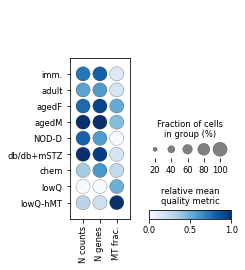

In [58]:
# Quality scores
qcs=['n_counts', 'n_genes', 'mt_frac']
qcs_map={'n_counts':'N counts', 'n_genes':'N genes', 'mt_frac':'MT frac.'}
adata_temp=sc.AnnData(adata_rn_b.obs[qcs])
adata_temp.obs['leiden_r1.5_parsed']=adata_rn_b.obs['leiden_r1.5_parsed']
adata_temp.var_names=[qcs_map[v] for v in adata_temp.var_names]
fig,ax=plt.subplots(
    figsize=(adata_temp.shape[1]*0.3+2, 
             adata_rn_b.obs['leiden_r1.5_parsed'].nunique()*0.3+1.2)
)
sc.pl.dotplot(adata_temp,var_names=list(qcs_map.values()),cmap='Blues',
               colorbar_title='relative mean\nquality metric',
              groupby='leiden_r1.5_parsed',standard_scale='var',ax=ax,show=False)
plt.savefig(path_fig+'dotplot_beta_CLcoarse_QC.png',dpi=300,bbox_inches='tight')
del adata_temp

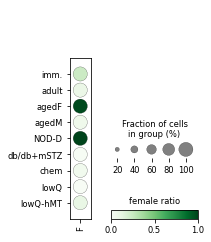

In [59]:
# Sex
# Map sex to numbers. use all >0 as else will affect circle size. 
# As normalised from 0 to 1 anyway it can be 2-1 here
adata_temp=sc.AnnData(
    pd.DataFrame(adata_rn_b.obs['sex'].map({'female':2,'male':1}).rename('F')))
adata_temp.obs['leiden_r1.5_parsed']=adata_rn_b.obs['leiden_r1.5_parsed']
fig,ax=plt.subplots(
    figsize=(adata_temp.shape[1]*0.3+2, 
             adata_rn_b.obs['leiden_r1.5_parsed'].nunique()*0.3+1.2)
)
sc.pl.dotplot(adata_temp,var_names='F',cmap='Greens',
               colorbar_title='female ratio',
              groupby='leiden_r1.5_parsed',standard_scale='var',ax=ax,show=False)
plt.savefig(path_fig+'dotplot_beta_CLcoarse_sex.png',dpi=300,bbox_inches='tight')
del adata_temp

## Comparison of fine and coarse cell subtypes
Note: This can be run only after computing the fine beta cell clusters in the other notebook.

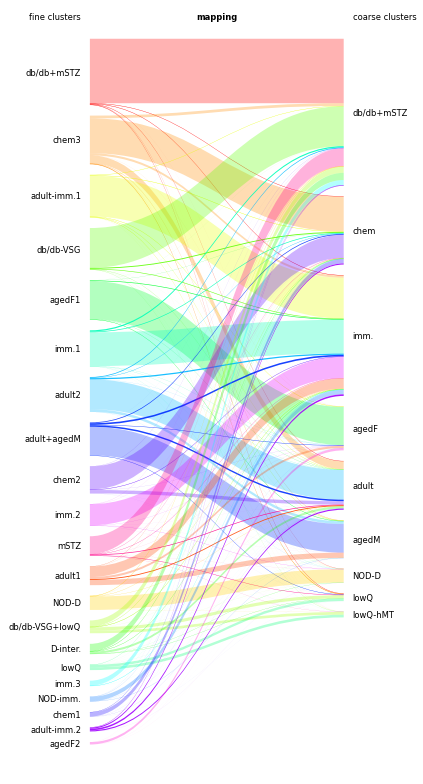

In [60]:
# Sankey plot
fig,ax=plt.subplots(figsize=(6,11))
fig=sankey.sankey(adata_rn_b.obs['hc_gene_programs_parsed'],adata_rn_b.obs['leiden_r1.5_parsed'],
                  title="mapping",
                  title_left="fine clusters",
                  title_right="coarse clusters",
                  ax=ax)
fig.tight_layout()
plt.savefig(path_fig+'sankey_beta_CLcoarse_CLfine.png',dpi=300,bbox_inches='tight')

Cluster overlap normalized by fine clusters. Row/column annotation shows n cells in each cluster.

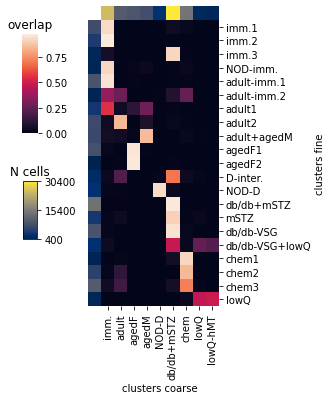

In [61]:
# Overlap between clusters as rati of smaller clusters
overlap=pd.crosstab(adata_rn_b.obs['hc_gene_programs_parsed'],
                    adata_rn_b.obs['leiden_r1.5_parsed'],normalize='index')
n_cols=adata_rn_b.obs['leiden_r1.5_parsed'].value_counts()[overlap.columns]
n_rows=adata_rn_b.obs['hc_gene_programs_parsed'].value_counts()[overlap.index]
overlap.index.name='clusters fine'
overlap.columns.name='clusters coarse'

# Colorscale
# Round scale to certain precision
round_to=100
min_n=math.floor(min(n_cols.min(),n_rows.min())/round_to)*round_to
max_n=math.ceil(max(n_cols.max(),n_rows.max()) /round_to)*round_to        
# Make colorscale colors
normalize = mcolors.Normalize(vmin=min_n,  vmax=max_n)
cmap=cm.cividis
col_colors=n_cols.apply(lambda n:cmap(normalize(n))).rename(None)
row_colors=n_rows.apply(lambda n:cmap(normalize(n))).rename(None)

# Heatmap
w_dend=1.5
w_colors=0.3
nrow=overlap.shape[0]*0.24
ncol=overlap.shape[1]*0.3
w=ncol+w_colors+w_dend
h=nrow+w_colors+w_dend
g=sb.clustermap(overlap,col_colors=col_colors,row_colors=row_colors,
                col_cluster=False,row_cluster=False,
               figsize=(w,h),
                colors_ratio=(w_colors/w,0.8*w_colors/h),
                dendrogram_ratio=(w_dend/w,w_dend/h),
               xticklabels=True,yticklabels=True,
               cbar_pos=(0.03,0.55,0.05,0.2))
g.ax_cbar.set_title('overlap')   

# Legend N cells
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
ax=g.fig.add_subplot(223)
cbar=plt.colorbar(scalarmappaple,location='left',ticks=[
    min_n, math.ceil((max_n+min_n)/(round_to*2))*round_to,max_n],
             pad=1.1,aspect=4)
cbar.ax.set_title('N cells')
cbar.ax.yaxis.set_ticks_position('right')
ax.axis('off')

#remove dendrogram
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

# remove color ticks
g.ax_row_colors.tick_params(axis='both', which='both', length=0)
g.ax_col_colors.tick_params(axis='both', which='both', length=0)

plt.savefig(path_fig+'heatmap_beta_CLcoarse_CLfine.png',dpi=300,bbox_inches='tight')

Same as above, but using jaccard index

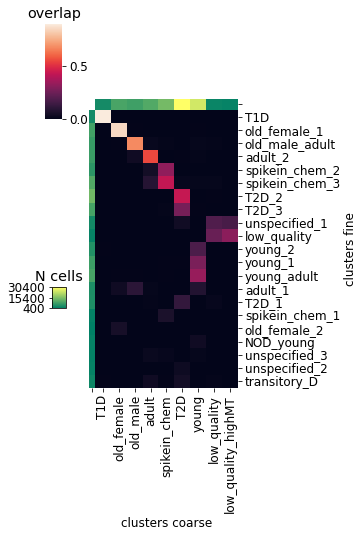

In [147]:
# Overlap between clusters as rati of smaller clusters
overlap=pd.crosstab(adata_rn_b.obs['hc_gene_programs_parsed'],
                    adata_rn_b.obs['leiden_r1.5_parsed'],normalize=False)
rowsums=overlap.sum(axis=1)
colsums=overlap.sum(axis=0)
for i in range(overlap.shape[0]):
    for j in range(overlap.shape[1]):
        o=overlap.iat[i,j]
        overlap.iat[i,j]=o/(rowsums.iat[i]+colsums.iat[j]-o)
n_cols=adata_rn_b.obs['leiden_r1.5_parsed'].value_counts()[overlap.columns]
n_rows=adata_rn_b.obs['hc_gene_programs_parsed'].value_counts()[overlap.index]
overlap.index.name='clusters fine'
overlap.columns.name='clusters coarse'

# Colorscale
# Round scale to certain precision
round_to=100
min_n=math.floor(min(n_cols.min(),n_rows.min())/round_to)*round_to
max_n=math.ceil(max(n_cols.max(),n_rows.max()) /round_to)*round_to        
# Make colorscale colors
normalize = mcolors.Normalize(vmin=min_n,  vmax=max_n)
cmap=cm.summer
col_colors=n_cols.apply(lambda n:cmap(normalize(n))).rename(None)
row_colors=n_rows.apply(lambda n:cmap(normalize(n))).rename(None)

# Heatmap
g=sb.clustermap(overlap,col_colors=col_colors,row_colors=row_colors,
               figsize=(overlap.shape[1]*0.4+1,overlap.shape[0]*0.35),
               xticklabels=True,yticklabels=True)
g.ax_cbar.set_title('overlap')   

# Legend N cells
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
ax=g.fig.add_subplot(223)
cbar=plt.colorbar(scalarmappaple,location='left',ticks=[
    min_n, math.ceil((max_n+min_n)/(round_to*2))*round_to,max_n],
             pad=1.1,aspect=1.5)
cbar.ax.set_title('N cells')
ax.axis('off')

#remove dendrogram
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

C: jaccard index is not ok as some fine clusters look like they belong to coarse clusters less since they are smaller. Thus it is also not clear in which clusters they map (e.g. unspecified 3).